# Burn mapping validation
This script shows the workflow of roc (Receiver operating characteristic) analysis of burn mapping with fire perimeters polygons

## import the required modules 
import the validationtoolbox for validation

In [1]:
import xarray as xr
import numpy as np
import validationtoolbox
import matplotlib.pyplot as plt
%matplotlib inline

## load the severity map
load a saved netcdf file for the severity for central plateau in 2016 for validation 

the severity mapping steps can also be inserted here 

In [2]:
sev = xr.open_dataset('/g/data/xc0/project/Burn_Mapping/TestSites/BurnArea_SirIvan_method2.nc')

## conver the severity to a burned/burned mask for validation
use the burnpixel_masking from the validation toolbox

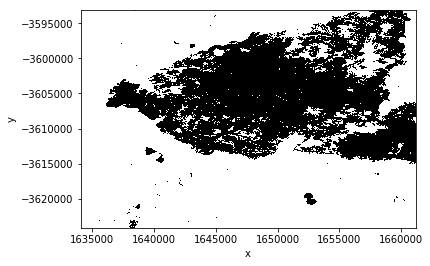

In [3]:
def burnpixel_masking(data):
    """
    This function converts the severity map into a burn pixel mask
    Required input:
    data: severity data in 2D, e.g. output from severity_mapping in the changedection.py
    """
    Burnpixel = data.BurnArea
    Burnpixel.data[Burnpixel.data>1]=1
    return Burnpixel
Burnpixel = burnpixel_masking(sev)
Burnpixel.plot.imshow(cmap='binary',add_colorbar=False)

## seperate the burned area into forest burned and none forest burned area
use the "treecover_masking" tool to generate the tree cover mask for the given region.

Required inputs:

    "year" should be before the bushfire, 
    "data" the Burnpixel with x,y
    "prctg" the treecover fraction used for forest mapping, default is 60
Outputs:

    forest mask, 1 for forest 0 for none forest
    none-forest mask, 1 for none-forest mask 0 for forest
    

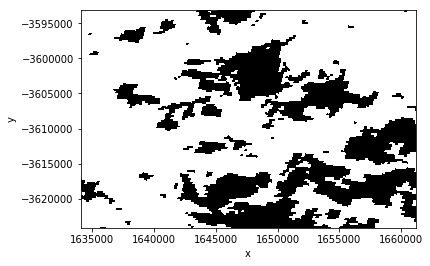

In [4]:
mask=validationtoolbox.treecover_masking(year=2017,data=Burnpixel,prctg=60)
mask.ForestMask.plot.imshow(cmap='binary',add_colorbar=False)

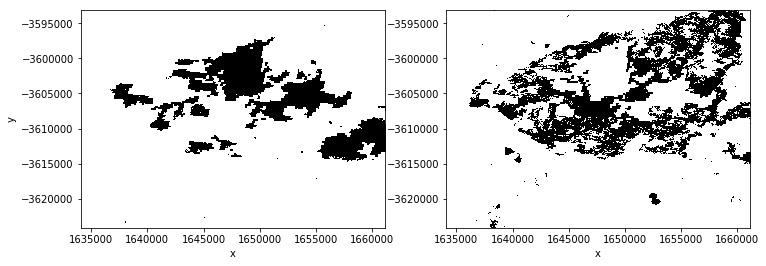

In [5]:
ForestBurned = Burnpixel*mask.ForestMask # burned pixel found in the forest area
NoneForestBurned = Burnpixel*mask.NoneForestMask # burned pixel found in the non-forest area
fig,axes=plt.subplots(ncols=2,figsize=[12,4])
ForestBurned.plot.imshow(ax=axes[0],cmap='binary',add_colorbar=False)
NoneForestBurned.plot.imshow(ax=axes[1],cmap='binary',add_colorbar=False)

## generate validation mask for roc analysis
use "CreateValidatedBurnMask" for creating corresponding validation mask from the shapefiles of fire perimeters polygons

required inputs:

    BurnPixel: burned pixel 
    State: abbrev of the state name 
    Validation_period: start and end
    
output mask includes the mask at each time step, sum up if a single mask required


In [6]:
ValidationMask=validationtoolbox.CreateValidatedBurnMask(Burnpixel,State='NSW', Validation_period=("2017-01-01","2017-12-31"))
ValidationMask = ValidationMask.sum('time') #create one mask with all the burned area

I am densified (external_values, 72 elements)


## Validation for forest and non-forest burnt
If use "validationtoolbox.validate", forest and non-forest will be combined and validate together
If use "validationtoolbox.validate_forest_grass", forest and non-forest will be combined and validate separately but shown in the same figure

The following example shows the validation for the corrected mapped forest burnt in darker green and non-forest burnt in lighter green

The false positive and truth positive rate for forest burnt area: 0.000, 0.967
The false positive and truth positive rate for non-forest burnt area: 0.008, 0.683


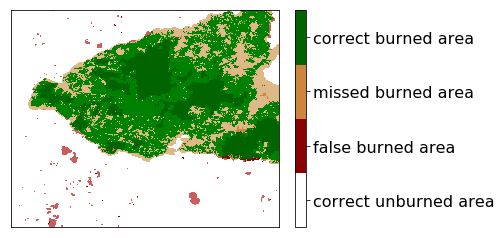

In [7]:
a,b = validationtoolbox.validate_forest_grass(Test_Array = Burnpixel, Validated_Array = ValidationMask,Mask = mask, plot=True)
print('The false positive and truth positive rate for forest burnt area: %.3f, %.3f' %(a[0],a[1]))
print('The false positive and truth positive rate for non-forest burnt area: %.3f, %.3f' %(b[0],b[1]))

## Confidence level 
Overlay the mapped burn area with hotspot data with 4km buffer

Or use the hotspot data for further filtering

In [10]:
extent = [np.min(sev.x.data),np.max(sev.x.data),np.min(sev.y.data),np.max(sev.y.data)]
year = 2017 #year for hotspot data

In [11]:
polygons = validationtoolbox.hotspot_polygon(year,extent,4000) # generate hotspot polygons with 4km buffer


In [12]:
#generate the mask for hotspot data for filtering or overlay
coords = Burnpixel.coords
if polygons.type=='MultiPolygon':
    HotspotMask=xr.DataArray()
    for polygon in polygons:
        HotspotMask_tmp =  validationtoolbox.outline_to_mask(polygon.exterior, coords['x'], coords['y'])
        HotspotMask = HotspotMask_tmp + HotspotMask
if polygons.type=='Polygon':
    HotspotMask =  validationtoolbox.outline_to_mask(polygons.exterior, coords['x'], coords['y'])
    HotspotMask=xr.DataArray(HotspotMask, coords=coords, dims=('y', 'x'))

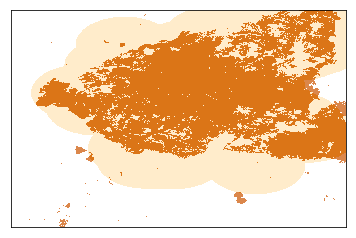

In [15]:
#Hotspot with 4km buffer in light orange and the burnt area in dark orange
from matplotlib.colors import ListedColormap
cMap = ListedColormap(['white','orange'])
fig,axes = plt.subplots()
cax=HotspotMask.plot.imshow(levels=[0,1,2],cmap=cMap,add_colorbar=False,alpha=1)
cMap2 = ListedColormap(['white','chocolate'])
cax=Burnpixel.plot.imshow(ax=axes,levels=[0,1,2],cmap=cMap2,add_colorbar=False,alpha=0.8)
cax.axes.get_xaxis().set_visible(False)
cax.axes.get_yaxis().set_visible(False)